# Импорт необходимых библиотек

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install pytorch-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 27.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-ma

In [3]:
! pip install pymorphy3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 49.7 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import torch

import string
import re

from tqdm import tqdm, trange, tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

import random
import pymorphy3

import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification, WarmupLinearSchedule
from tqdm import tqdm, trange, tqdm_notebook
import io
from IPython.display import clear_output

In [6]:
import os

In [7]:
from sklearn.metrics import classification_report

In [8]:
from collections import Counter

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla T4


In [10]:
dataset = pd.read_excel('/content/drive/MyDrive/Гилфорд Маг Диплом Розовская/New results/cleaned data Guilford.xlsx')

dataset.head(5)

,Unnamed: 0,ID,attempt,n,answer,origNew,prepr_text,simple_category
0,0,PTxGzRMvLY,1,1,сложить из спичек домик,3,сложить из спичек домик,5
1,1,PTxGzRMvLY,1,2,использовать спички как опору чего - нибудь,5,использовать спички как опору чего нибудь,6
2,2,PTxGzRMvLY,1,3,спичками мжно ковыряться в зубах,3,спичками мжно ковыряться в зубах,6
3,3,PTxGzRMvLY,1,4,"если сложить спички в виде колодца, можно испо...",5,если сложить спички в виде колодца можно испол...,6
4,4,PTxGzRMvLY,1,5,"если разукрасить спички, то можно сложить их н...",2,если разукрасить спички то можно сложить их на...,5


Сразу смотрим, сколько примеров на каждый балл оригинальности:

In [11]:
dataset.origNew.value_counts()

origNew
5    3330
4    2187
3    1480
2     285
6      51
1      23
Name: count, dtype: int64

# Зафиксируем seed для воспроизводимости

In [12]:
#фиксируем seed
def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

RANDOM_SEED = 1500

init_random_seed(value=RANDOM_SEED)

# Fine-tuning BERT

In [13]:
sentences_bert = ["[CLS] " + sentence + " [SEP]" for sentence in dataset['prepr_text'].values]

In [14]:
# переопределим баллы оригинальности от 0
#Так я пыталась решить ошибку, которая появлялась на этапе обучения модели
#RuntimeError: CUDA error: device-side assert triggered

# UPD: + объединить маленькие классы

def get_classes():
  classes = []
  for value in dataset.origNew:
    if value==1 or value ==2 or value == 3: # объединяем 1, 2 и 3 в один класс
      cls = int(0)
    elif value==4: # просто переопределяем
      cls = int(1)
    else: # объединяем 5 и 6 в один класс
      cls = int(2)
    classes.append(cls)

  dataset.origNew = classes
  dataset.origNew.unique()

In [15]:
# !!! 6 КЛАССОВ
classes = [int(x)-1 for x in dataset.origNew.values]

dataset.origNew = classes

In [16]:
# !!! 3 КЛАССА
#get_classes()

In [17]:
dataset.origNew.value_counts()

origNew
4    3330
3    2187
2    1480
1     285
5      51
0      23
Name: count, dtype: int64

In [18]:
type(dataset.origNew[0])

numpy.int64

In [19]:
# целочисленные баллы оригинальности превращаются в лейблы классов
labels = dataset.origNew

In [20]:
train_sentences, test_sentences, train_y, test_y = train_test_split(sentences_bert,
                                                                    labels, test_size=0.2, stratify=labels, random_state=RANDOM_SEED)

In [21]:
from pytorch_transformers import BertTokenizer, BertConfig

# здесь меняем max_len
# 85 получилось оптимально

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# base -model | uncased - все слова в нижнем регистре
tokenized_texts_train = [tokenizer.tokenize(sent[:85]) for sent in train_sentences]
tokenized_texts_test = [tokenizer.tokenize(sent[:85]) for sent in test_sentences]
print(tokenized_texts_train[0])

100%|██████████| 231508/231508 [00:00<00:00, 319142.48B/s]


['[CLS]', 'д', '##л', '##я', 'т', '##о', '##г', '##о', 'ч', '##т', '##о', '##б', '##ы', 'п', '##о', '##р', '##т', '##и', '##т', '##ь', 'д', '##в', '##е', '##р', '##н', '##о', '##и', 'з', '##а', '##м', '##о', '##к', '[SEP]']


In [22]:
sum([1 for sent in train_sentences if len(sent) > 70])

676

In [23]:
len(tokenized_texts_train)

5884

BERTу нужно предоставить специальный формат входных данных.


- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: вектор из нулей и единиц. В нашем случае нули обозначают негативную эмоциональную окраску, единицы - положительную.
- **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

In [24]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_train]
input_ids = pad_sequences(
    input_ids,
    maxlen=128,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [25]:
sum([len(text) for text in tokenized_texts_train])/len(tokenized_texts_train)

31.29860639021074

In [26]:
train_inputs = input_ids
train_labels = train_y
train_masks = attention_masks

val_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test]
val_input_ids = pad_sequences(
    val_input_ids,
    maxlen=128,
    dtype="long",
    truncating="post",
    padding="post"
)
val_attention_masks = [[float(i>0) for i in seq] for seq in val_input_ids]

validation_inputs = val_input_ids
validation_labels = test_y
validation_masks = val_attention_masks

In [27]:
train_inputs.shape

(5884, 128)

In [28]:
train_labels.shape

(5884,)

In [29]:
train_inputs = torch.tensor(train_inputs)
train_labels = np.array(train_labels)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [30]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = np.array(validation_labels)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [31]:
train_labels.shape, validation_labels.shape

(torch.Size([5884]), torch.Size([1472]))

Можно попробовать разные batch_size: 8, 16, 32

In [32]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size= 32
)

In [33]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size= 32
)

# Обучение модели Bert For Sequence Classification:

In [34]:
from pytorch_transformers import AdamW, BertForSequenceClassification

In [35]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)

100%|██████████| 440473133/440473133 [00:25<00:00, 16943482.63B/s]


In [36]:
model = model.to(device)

#RuntimeError: CUDA error: device-side assert triggered
#CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
#For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
#Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions

In [37]:
epochs = 10

optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

lmbda = lambda epoch: 0.65 ** epoch
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

max_grad_norm_clipping = 1

In [38]:
len(train_dataloader)

184

In [39]:
def train(model, train_dataloader, optimizer, EPOCH_AMOUNT, with_clipping=False,max_grad_norm_clipping=1):
    # Будем сохранять loss во время обучения
    # и рисовать график в режиме реального времени
    train_loss_set = []
    train_loss = 0


    # Обучение
    # Переводим модель в training mode
    model.train()

    for _ in range(EPOCH_AMOUNT):
        for step, batch in enumerate(train_dataloader):
            # добавляем батч для вычисления на GPU
            batch = tuple(t.to(device) for t in batch)

            # Распаковываем данные из dataloader
            b_input_ids, b_input_mask, b_labels = batch

            # если не сделать .zero_grad(), градиенты будут накапливаться
            optimizer.zero_grad()

            # Forward pass
            loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            if len(train_loss_set) > 0:
              if loss[0].item() < min(train_loss_set):
                print(round(loss[0].item(),3))
                print(min(train_loss_set))

                # чтобы хранилища google хватало, предыдущике файлы будем сразу удалять
                f = '/content/drive/MyDrive/Гилфорд Маг Диплом Розовская/New results/BRT2_orig_6_'+str(round(min(train_loss_set),3))+'.ckpt'
                #f = '/content/drive/MyDrive/Лорочкина папочка/BRT_orig_'+str(round(min(train_loss_set),3))+'.ckpt'
                if os.path.isfile(f):
                  os.remove(f)

                torch.save(model.state_dict(),
                           '/content/drive/MyDrive/Гилфорд Маг Диплом Розовская/New results/BRT2_orig_6_' + str(round(loss[0].item(),3))+'.ckpt')
                #torch.save(model.state_dict(),
                           #'/content/drive/MyDrive/Лорочкина папочка/BRT_orig_' + str(round(loss[0].item(),3)) + '.ckpt')
            train_loss_set.append(loss[0].item())

            # Backward pass
            loss[0].backward()

            if with_clipping:
                # Gradient clipping is not in AdamW anymore (so you can use amp without issue)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm_clipping)

            # Обновляем параметры и делаем шаг используя посчитанные градиенты
            optimizer.step()
            #scheduler.step()

            # Обновляем loss
            train_loss += loss[0].item()

            # Рисуем график
            clear_output(True)
            plt.figure(figsize=(12, 6))
            plt.plot(train_loss_set)
            plt.title("Training loss")
            plt.xlabel("Batch")
            plt.ylabel("Loss")
            plt.grid()
            plt.show()

        print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))
        print(min(train_loss_set))

In [40]:
def test(model, dataloader, name_dtlder='Test'):
    # Валидация
    # Переводим модель в evaluation mode
    model.eval()
    test_preds, test_labels = [], []

    n = 0

    model_name = input('как сохранить результаты валидации?')
    f = '/content/drive/MyDrive/Гилфорд Маг Диплом Розовская/New results/'+model_name+'val_acc_scrore.txt'

    with open(f, 'w', encoding='utf-8') as rec:

      for batch in tqdm_notebook(dataloader):
          # добавляем батч для вычисления на GPU
          batch = tuple(t.to(device) for t in batch)

          # Распаковываем данные из dataloader
          b_input_ids, b_input_mask, b_labels = batch

          # При использовании .no_grad() модель не будет считать и хранить градиенты.
          # Это ускорит процесс предсказания меток для тестовых данных.
          with torch.no_grad():
              logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

          # Перемещаем logits и метки классов на CPU для дальнейшей работы
          logits = logits[0].detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Сохраняем предсказанные классы и ground truth
          batch_preds = np.argmax(logits, axis=1)

          if len(label_ids.shape) == 1:
              batch_labels = label_ids
          else:
              batch_labels = np.concatenate(label_ids)
          test_preds.extend(batch_preds)
          test_labels.extend(batch_labels)
          batch_preds = np.argmax(logits, axis=1)

          print(n, ' val accuracy score: ', accuracy_score(test_labels, test_preds))
          rec.write(str(n)+' val accuracy score: '+str(accuracy_score(test_labels, test_preds))+'\n')

          n += 1

      acc_score = accuracy_score(test_labels, test_preds)
      print('Процент правильных предсказаний на {0} выборке составил:  f1 = {1:.2f}%'.format(name_dtlder,
                                                                                             f1_score(test_labels,
                                                                                                      test_preds,
                                                                                                      average='macro') * 100))
      rec.write('Процент правильных предсказаний на {0} выборке составил:  f1 = {1:.2f}%'.format(name_dtlder,
                                                                                             f1_score(test_labels,
                                                                                                      test_preds,
                                                                                                      average='macro') * 100))
      rec.close()

    return test_preds, test_labels

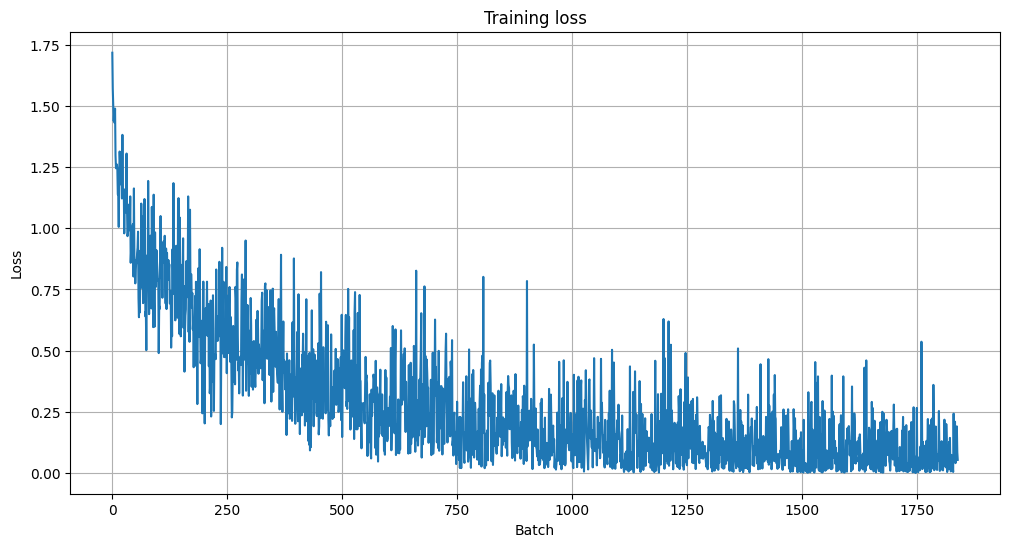

Loss на обучающей выборке: 2.86615
0.0012992476113140583


In [ ]:
train(model, train_dataloader, optimizer, epochs, with_clipping=1)

#RuntimeError: CUDA error: device-side assert triggered
#CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
#For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
#Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions

# Валидация:

In [41]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Гилфорд Маг Диплом Розовская/models saved/BRT2_orig_6_0.01.ckpt'))

# если вдруг не на gpu
#, map_location=torch.device('cpu')))

<All keys matched successfully>

In [42]:
val_preds, val_labels = test(model, validation_dataloader, name_dtlder='VAl')

как сохранить результаты валидации?BRT2_orig_6_0.01


  0%|          | 0/46 [00:00<?, ?it/s]

0  val accuracy score:  0.9375
1  val accuracy score:  0.90625
2  val accuracy score:  0.875
3  val accuracy score:  0.875
4  val accuracy score:  0.88125
5  val accuracy score:  0.8541666666666666
6  val accuracy score:  0.8526785714285714
7  val accuracy score:  0.84765625
8  val accuracy score:  0.8541666666666666
9  val accuracy score:  0.84375
10  val accuracy score:  0.84375
11  val accuracy score:  0.8411458333333334
12  val accuracy score:  0.8365384615384616
13  val accuracy score:  0.8348214285714286
14  val accuracy score:  0.8229166666666666
15  val accuracy score:  0.8125
16  val accuracy score:  0.8125
17  val accuracy score:  0.8177083333333334
18  val accuracy score:  0.8207236842105263
19  val accuracy score:  0.81875
20  val accuracy score:  0.8184523809523809
21  val accuracy score:  0.8181818181818182
22  val accuracy score:  0.8179347826086957
23  val accuracy score:  0.8190104166666666
24  val accuracy score:  0.81875
25  val accuracy score:  0.8209134615384616
26

In [43]:
target_names = [str(c) for c in dataset.origNew.unique()]
target_names = set(target_names)
target_names

{'0', '1', '2', '3', '4', '5'}

In [44]:
print(classification_report(val_labels, val_preds))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.77      0.63      0.69        57
           2       0.78      0.85      0.81       296
           3       0.77      0.77      0.77       438
           4       0.85      0.85      0.85       666
           5       0.00      0.00      0.00        10

    accuracy                           0.81      1472
   macro avg       0.63      0.62      0.62      1472
weighted avg       0.81      0.81      0.81      1472

